In [1]:
import sys

sys.path.append('../data')
sys.path.append('..')
sys.path.append('../inference')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ai_trainer import Personal_Trainer
import squat_separation as ss
import pickle
import os
import random as rnd
from collections import defaultdict

%matplotlib inline

#Step 1: Instantiate our personal trainer and load preprocessed data

In [2]:
pt = Personal_Trainer('NeckY')
pt.load_squats(os.path.join('../data/data_sets','multipleClass4.p'))

#Step 2: Extract features 

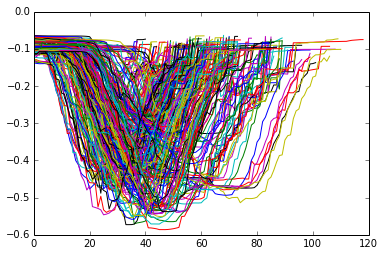

In [3]:
plt.clf()
for squat in pt.get_squats():
    plt.plot(-squat['NeckY'])

In [4]:
X, Y, file_names = pt.extract_advanced_features(multiples=[0.2, 0.4, 0.6, 0.8])

#Step 3: Classification

##Scale features and define testing functions

In [299]:
from sklearn import preprocessing
from sklearn import cross_validation
from sklearn import metrics
import random

def predictProbs(X,y,X_test, clf_class, **kwargs):
    clf = clf_class(**kwargs)
    clf.fit(X ,y)
    return clf.predict_proba(X_test)

def predict_labels(X, y, X_test, clf_class, **kwargs):
    clf = clf_class(**kwargs)
    try: 
        clf.fit(X ,y)
    except:
        return []
#     try:
#         print "Labels ", clf.classes_
#     except: 
#         print "Could not print classes"
    return clf.predict(X_test)

def stratified_cv(X, y, clf_class, shuffle=True, n_folds=10, **kwargs):
    stratified_k_fold = cross_validation.StratifiedKFold(y, n_folds=n_folds, shuffle=shuffle)
    y_pred = y.copy()
    for i, j in stratified_k_fold:
        X_train, X_test = X[i], X[j]
        y_train = y[i]
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        y_pred[j] = clf.predict(X_test)
    return y_pred

def print_analysis(counts):
    try:
#         print 'True Negative: %f percent, %d total' % ((float(counts['0_0'])/float(counts['0_1']+counts['0_0']+counts['0_-1'])), (float(counts['0_1']) + float(counts['0_0']) + float(counts['0_-1'])))
#         print 'False Negative: %d total' % (float(counts['1_0'])+ float(counts['-1_0']))
#         print 'True Positive: %f percent, %d total' % (((float(counts['1_1']) + float(counts['-1_-1']))/float(counts['-1_1']+counts['-1_-1']+counts['-1_0']+counts['1_1']+counts['1_-1']+counts['1_0'])), (float(counts['-1_1']+counts['-1_-1']+counts['-1_0']+counts['1_1']+counts['1_-1']+counts['1_0'])))
#         print 'False Positive: %d total' % (float(counts['0_1'])+ float(counts['0_-1']))
#         print 'F-score = %f' % (2*(float(counts['1_1']) + float(counts['-1_-1']))/(2*(float(counts['1_1']) + float(counts['-1_-1'])) + (float(counts['0_1'])+ float(counts['0_-1'])) + (float(counts['1_0'])+ float(counts['-1_0']))))
#         print '\n\n'
        return 2*(float(counts['1_1']) + float(counts['-1_-1']))/(2*(float(counts['1_1']) + float(counts['-1_-1'])) + (float(counts['0_1'])+ float(counts['0_-1'])) + (float(counts['1_0'])+ float(counts['-1_0'])))
    except Exception as e:
        print e

def evaluate(labels, y_test, y_pred):
    if len(y_test) != len (y_pred):
        return 0
    for index, y in enumerate(y_test):
        if y_pred[index] == y:
            if y == 1:
                labels['1_1'] +=1
            elif y == 0:
                labels['0_0'] +=1
            elif y == -1:
                labels['-1_-1'] +=1
        elif y == 1:
            if y_pred[index] == 0:
                labels['1_0'] += 1
            if y_pred[index] == -1:
                labels['1_-1'] += 1
        elif y == 0:
            if y_pred[index] == -1:
                labels['0_-1'] += 1
            elif y_pred[index] == 1:
                labels['0_1'] += 1
        elif y == -1:
            if y_pred[index] == 0:
                labels['-1_0'] +=1
            elif y_pred[index] == 1:
                labels['-1_1'] += 1
        
    return metrics.accuracy_score(y_test,y_pred)


def rnd_prediction(training_data, labels, file_names, clf_class, toIgnore=None, num_iters=10, **kwargs):
    
    num_training_examples = [x*10 for x in range(1,20)]
    
    accuracy = [0 for _ in range(len(num_training_examples))]
    accuracy_train = [0 for _ in range(len(num_training_examples))]
    f_score = []
    f_score_training = []

    #=====[ Randomly leave out one of the files and test on it num_iter times ]======
    names = list(set(file_names))

    for ind, count in enumerate(num_training_examples):
        
        counts = {'-1_1':0,'-1_-1':0,'-1_0':0,'0_0':0,'0_1':0,'0_-1':0, '1_0':0, '1_-1':0, '1_1':0}
        training_counts = {'-1_1':0,'-1_-1':0,'-1_0':0,'0_0':0,'0_1':0,'0_-1':0, '1_0':0, '1_-1':0, '1_1':0}

        for name in names:
            toIgnore = name
            
            X = np.array([x for index, x in enumerate(training_data) if file_names[index] != toIgnore])
            Y = np.array([y for index, y in enumerate(labels) if file_names[index] != toIgnore])
        
            X_test = [x for index, x in enumerate(training_data) if file_names[index] == toIgnore]
            y_test = [y for index, y in enumerate(labels) if file_names[index] == toIgnore]
        
            random.seed()
            indices = random.sample(range(len(X)),count)
            X_new = X[indices]
            Y_new = Y[indices]
        
            local_accuracy = evaluate(counts, y_test, predict_labels(X_new, Y_new, X_test, clf_class, **kwargs))
            local_accuracy_train = evaluate(training_counts, Y_new, predict_labels(X_new, Y_new, X_new, clf_class, **kwargs))

            accuracy[ind] += local_accuracy
            accuracy_train[ind] += local_accuracy_train
            
        accuracy[ind]/=len(names)
        accuracy_train[ind]/=len(names)
        f_score.append(print_analysis(counts))
        f_score_training.append(print_analysis(training_counts))
        
    return f_score, f_score_training, accuracy, accuracy_train
#         f1_score += local_f1
#         print predictProbs(X,Y,X_test,clf_class,**kwargs)
#         print(toIgnore, local_accuracy)

#     print '############ TRAINING DATA ############'
#     print accuracy_train/len(names), '\n'
#     print_analysis(training_counts), '\n'
#     print '############ TEST DATA ############'
#     print accuracy/len(names), '\n'
#     print_analysis(counts),'\n\n'
#     return print_analysis(counts), accuracy/len(names), print_analysis(training_counts), accuracy_train/len(names)

In [295]:
from sklearn import preprocessing
from sklearn import cross_validation
from sklearn import metrics
import random

def predictProbs(X,y,X_test, clf_class, **kwargs):
    clf = clf_class(**kwargs)
    clf.fit(X ,y)
    return clf.predict_proba(X_test)

def predict_labels(X, y, X_test, clf_class, **kwargs):
    clf = clf_class(**kwargs)
    try: 
        clf.fit(X ,y)
    except:
        return []
#     try:
#         print "Labels ", clf.classes_
#     except: 
#         print "Could not print classes"
    return clf.predict(X_test)

def stratified_cv(X, y, clf_class, shuffle=True, n_folds=10, **kwargs):
    stratified_k_fold = cross_validation.StratifiedKFold(y, n_folds=n_folds, shuffle=shuffle)
    y_pred = y.copy()
    for i, j in stratified_k_fold:
        X_train, X_test = X[i], X[j]
        y_train = y[i]
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        y_pred[j] = clf.predict(X_test)
    return y_pred

def print_analysis(counts):
    try:
        print 'True Negative: %f percent, %d total' % ((float(counts['0_0'])/float(counts['0_1']+counts['0_0']+counts['0_-1'])), (float(counts['0_1']) + float(counts['0_0']) + float(counts['0_-1'])))
        print 'False Negative: %d total' % (float(counts['1_0'])+ float(counts['-1_0']))
        print 'True Positive: %f percent, %d total' % (((float(counts['1_1']) + float(counts['-1_-1']))/float(counts['-1_1']+counts['-1_-1']+counts['-1_0']+counts['1_1']+counts['1_-1']+counts['1_0'])), (float(counts['-1_1']+counts['-1_-1']+counts['-1_0']+counts['1_1']+counts['1_-1']+counts['1_0'])))
        print 'False Positive: %d total' % (float(counts['0_1'])+ float(counts['0_-1']))
        print 'F-score = %f' % (2*(float(counts['1_1']) + float(counts['-1_-1']))/(2*(float(counts['1_1']) + float(counts['-1_-1'])) + (float(counts['0_1'])+ float(counts['0_-1'])) + (float(counts['1_0'])+ float(counts['-1_0']))))
        print '\n\n'
        return 2*(float(counts['1_1']) + float(counts['-1_-1']))/(2*(float(counts['1_1']) + float(counts['-1_-1'])) + (float(counts['0_1'])+ float(counts['0_-1'])) + (float(counts['1_0'])+ float(counts['-1_0'])))
    except Exception as e:
        print e

def evaluate(labels, y_test, y_pred):
    if len(y_test) != len (y_pred):
        return 0
    for index, y in enumerate(y_test):
        if y_pred[index] == y:
            if y == 1:
                labels['1_1'] +=1
            elif y == 0:
                labels['0_0'] +=1
            elif y == -1:
                labels['-1_-1'] +=1
        elif y == 1:
            if y_pred[index] == 0:
                labels['1_0'] += 1
            if y_pred[index] == -1:
                labels['1_-1'] += 1
        elif y == 0:
            if y_pred[index] == -1:
                labels['0_-1'] += 1
            elif y_pred[index] == 1:
                labels['0_1'] += 1
        elif y == -1:
            if y_pred[index] == 0:
                labels['-1_0'] +=1
            elif y_pred[index] == 1:
                labels['-1_1'] += 1
        
    return metrics.accuracy_score(y_test,y_pred)


def rnd_prediction(training_data, labels, file_names, clf_class, toIgnore=None, num_iters=10, **kwargs):
    
    
    accuracy = 0
    accuracy_train = 0

    #=====[ Randomly leave out one of the files and test on it num_iter times ]======
    names = list(set(file_names))
        
    counts = {'-1_1':0,'-1_-1':0,'-1_0':0,'0_0':0,'0_1':0,'0_-1':0, '1_0':0, '1_-1':0, '1_1':0}
    training_counts = {'-1_1':0,'-1_-1':0,'-1_0':0,'0_0':0,'0_1':0,'0_-1':0, '1_0':0, '1_-1':0, '1_1':0}

    for name in names:
        toIgnore = name

        X = np.array([x for index, x in enumerate(training_data) if file_names[index] != toIgnore])
        Y = np.array([y for index, y in enumerate(labels) if file_names[index] != toIgnore])

        X_test = [x for index, x in enumerate(training_data) if file_names[index] == toIgnore]
        y_test = [y for index, y in enumerate(labels) if file_names[index] == toIgnore]


        local_accuracy = evaluate(counts, y_test, predict_labels(X, Y, X_test, clf_class, **kwargs))
        local_accuracy_train = evaluate(training_counts, Y, predict_labels(X, Y, X, clf_class, **kwargs))

        accuracy += local_accuracy
        accuracy_train += local_accuracy_train

#     print '############ TRAINING DATA ############'
#     print accuracy_train/len(names), '\n'
#     print_analysis(training_counts), '\n'
#     print '############ TEST DATA ############'
#     print accuracy/len(names), '\n'
#     print_analysis(counts),'\n\n'
    return print_analysis(counts), accuracy/len(names), print_analysis(training_counts), accuracy_train/len(names)

##Test Various Classifiers

In [159]:
from sklearn import ensemble
from sklearn import svm
from sklearn import neighbors
from sklearn import linear_model
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import tree

##Build classifier for each feature set and test against individuals that have no input into the training set

In [16]:
def classify(feature_key, data_dir):
    print('Logistic Regression:           {:.2f}'.format(rnd_prediction(feature_key, data_dir, linear_model.LogisticRegression)))
    print('Support vector machine(SVM):   {:.2f}'.format(rnd_prediction(feature_key, data_dir, svm.SVC)))
    print('Random Forest Classifier:      {:.2f}'.format(rnd_prediction(feature_key, data_dir, ensemble.RandomForestClassifier)))

#Classify on entire training 

In [43]:
for key in X:
    x = X[key]
    y = Y[key]
    print '\n\n', key, '\n#############################'
    try:
        print('Logistic Regression:           {:.2f}'.format(metrics.accuracy_score(y, stratified_cv(x, y, linear_model.LogisticRegression))))
        print('Support vector machine(SVM):   {:.2f}'.format(metrics.accuracy_score(y, stratified_cv(x, y, svm.SVC))))
        print('Random Forest Classifier:      {:.2f}'.format(metrics.accuracy_score(y, stratified_cv(x, y, ensemble.RandomForestClassifier))))
    except Exception as e:
        print e



stance_width 
#############################
Logistic Regression:           0.94
Support vector machine(SVM):   0.95
Random Forest Classifier:      0.95


stance_alignment 
#############################
This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0


back_straight 
#############################
Logistic Regression:           0.88
Support vector machine(SVM):   0.87
Random Forest Classifier:      0.86


back_hip_angle 
#############################
Logistic Regression:           0.63
Support vector machine(SVM):   0.65
Random Forest Classifier:      0.75


bend_hips_knees 
#############################
Logistic Regression:           0.91
Support vector machine(SVM):   0.92
Random Forest Classifier:      0.92


squat_depth 
#############################
Logistic Regression:           0.86
Support vector machine(SVM):   0.86
Random Forest Classifier:      0.86


knees_over_toes 
#############################
Logistic Regression:     

#Classify with file_names left out

In [78]:
for key in X:
    x = X[key]
    y = Y[key]
    try:
        print '\n\n', key, '\n#############################\n\n'
#         print 'Logistic Regression'
#         rnd_prediction(x, y, file_names, linear_model.LogisticRegression)
#         print 'SVM'
#         rnd_prediction(x, y, file_names, svm.SVC)
        print 'Random Forest Classifier Optimized'
        rnd_prediction(x, y, file_names, ensemble.RandomForestClassifier, max_depth=8)
        print 'Random Forest Classifier'
        rnd_prediction(x, y, file_names, ensemble.RandomForestClassifier)
#         print 'Gradient Boosting'
#         rnd_prediction(x, y, file_names, GradientBoostingClassifier, n_estimators = 100, learning_rate = 0.1)
#         print 'Decision Tree'
#         rnd_prediction(x, y, file_names, tree.DecisionTreeClassifier)
    except Exception as e:
        print key, e

IndexError: arrays used as indices must be of integer (or boolean) type

#Classification Experimentation with varying sizes of states

In [30]:
X0, Y0, file_names = pt.extract_advanced_features(multiples=[0.5])

In [126]:
X00, Y00, file_names = pt.extract_all_advanced_features(multiples=[0.5])

In [31]:
X1, Y1, file_names = pt.extract_advanced_features(multiples=[0.25, 0.5, 0.75])

In [7]:
X10, Y10, file_names = pt.extract_all_advanced_features(multiples=[0.25, 0.5, 0.75])

In [165]:
X15, Y15, file_names = pt.extract_advanced_features(multiples=[0.2, 0.4, 0.6, 0.8])

In [8]:
X150, Y150, file_names = pt.extract_all_advanced_features(multiples=[0.2, 0.4, 0.6, 0.8])

In [151]:
X2, Y2, file_names = pt.extract_advanced_features(multiples=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [9]:
X20, Y20, file_names = pt.extract_all_advanced_features(multiples=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [275]:
X3, Y3, file_names = pt.extract_advanced_features(multiples=[0.05, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95])

In [10]:
X30, Y30, file_names = pt.extract_all_advanced_features(multiples=[0.05, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95])

In [11]:
X4, Y4, file_names = pt.extract_advanced_features(multiples=[float(x)/100 for x in range(100)])

In [12]:
X40 = np.concatenate([X4[x] for x in X4],axis=1)

In [19]:
def coalesce_twos(y):
    y_true = []
    for label in y:
        if label == 2:
            y_true.append(1)
        else:
            y_true.append(label)
    
    return y_true

toIgnore = ['stance_width', 'back_straight','back_hip_angle']

for key in Y:
    
    y = Y[key]

    X=X00

    # y = coalesce_twos(y)

    try:
        print '\n\n', key, '\n######################################\n\n'
        print 'Logistic Regression with L1'
        rnd_prediction(X, y, file_names, linear_model.LogisticRegression, penalty='l1')
        print 'SVM'
        rnd_prediction(X, y, file_names, svm.SVC, C=100)
        print 'Random Forest Classifier Optimized'
        rnd_prediction(X, y, file_names, ensemble.RandomForestClassifier)
        print 'Random Forest Classifier Optimized'
        rnd_prediction(X, y, file_names, ensemble.RandomForestClassifier, max_depth=15)
        print 'Random Forest Classifier'
        rnd_prediction(X, y, file_names, ensemble.RandomForestClassifier)
        print 'Gradient Boosting estimators plus learning rate'
        rnd_prediction(X, y, file_names, GradientBoostingClassifier, n_estimators = 100, learning_rate = 0.3)
        print 'Decision Tree w/ min_samples_split = 2 and entropy'
        rnd_prediction(X, y, file_names, tree.DecisionTreeClassifier, min_samples_split= 5, criterion="entropy")
    except Exception as e:
        print key, e



stance_width 
######################################


Logistic Regression with L1
True Negative: 0.937853 percent, 177 total
False Negative: 21 total
True Positive: 0.553191 percent, 47 total
False Positive: 11 total
F-score = 0.619048



True Negative: 1.000000 percent, 3009 total
False Negative: 0 total
True Positive: 1.000000 percent, 799 total
False Positive: 0 total
F-score = 1.000000



SVM
True Negative: 0.977401 percent, 177 total
False Negative: 19 total
True Positive: 0.595745 percent, 47 total
False Positive: 4 total
F-score = 0.708861



True Negative: 1.000000 percent, 3009 total
False Negative: 0 total
True Positive: 1.000000 percent, 799 total
False Positive: 0 total
F-score = 1.000000



Random Forest Classifier Optimized
True Negative: 0.971751 percent, 177 total
False Negative: 15 total
True Positive: 0.680851 percent, 47 total
False Positive: 5 total
F-score = 0.761905



True Negative: 0.999668 percent, 3009 total
False Negative: 0 total
True Positive: 1.000000 p

#Best performing classifiers squat components

In [296]:
#MAX FOR BEND HIPS KNEES

print 'Decision Tree'
rnd_prediction(X3['bend_hips_knees'], Y['bend_hips_knees'], file_names, tree.DecisionTreeClassifier, max_depth=3, criterion="entropy")

#extract advanced with X3 = [20] and component specific features
#X3, Y3, file_names = pt.extract_advanced_features(multiples=[0.05, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95])

Decision Tree
True Negative: 0.989899 percent, 198 total
False Negative: 11 total
True Positive: 0.576923 percent, 26 total
False Positive: 2 total
F-score = 0.697674



True Negative: 0.999703 percent, 3366 total
False Negative: 97 total
True Positive: 0.780543 percent, 442 total
False Positive: 1 total
F-score = 0.875635





(0.6976744186046512,
 0.94879159177404782,
 0.8756345177664975,
 0.97428464275647286)

In [ ]:
#Max for Stance Width

print 'Logistic Regression with L1'
rnd_prediction(X15['stance_width'], Y['stance_width'], file_names, linear_model.LogisticRegression, penalty='l1')

#extract advanced with X15 = 20 and component specific features
#X15, Y15, file_names = pt.extract_advanced_features(multiples=[0.2, 0.4, 0.6, 0.8])

In [ ]:
#Max for squat depth

print 'Logistic Regression with L1'
rnd_prediction(X15['squat_depth'], Y['squat_depth'], file_names, linear_model.LogisticRegression, penalty='l1')

#X0['squat_depth']

In [286]:
#Max for knees over toes
y = coalesce_twos(Y['knees_over_toes'])
print 'Decision Tree w/ min_samples_split = 5 and entropy'
sum = 0
acc = 0
for _ in range(10):
    a, b, c, d = rnd_prediction(X30, y, file_names, tree.DecisionTreeClassifier, max_depth=3, criterion="entropy")
    sum +=a
    acc +=b

sum/10
acc/10
#X3 with all features combined

Decision Tree w/ min_samples_split = 5 and entropy
True Negative: 0.876543 percent, 81 total
False Negative: 20 total
True Positive: 0.860140 percent, 143 total
False Positive: 10 total
F-score = 0.891304



True Negative: 0.981845 percent, 1377 total
False Negative: 204 total
True Positive: 0.916084 percent, 2431 total
False Positive: 25 total
F-score = 0.951100



True Negative: 0.876543 percent, 81 total
False Negative: 24 total
True Positive: 0.832168 percent, 143 total
False Positive: 10 total
F-score = 0.875000



True Negative: 0.981845 percent, 1377 total
False Negative: 205 total
True Positive: 0.915673 percent, 2431 total
False Positive: 25 total
F-score = 0.950876



True Negative: 0.851852 percent, 81 total
False Negative: 17 total
True Positive: 0.881119 percent, 143 total
False Positive: 12 total
F-score = 0.896797



True Negative: 0.981845 percent, 1377 total
False Negative: 203 total
True Positive: 0.916495 percent, 2431 total
False Positive: 25 total
F-score = 0.95132

0.86317112225006964

In [288]:
print sum/10
print acc/10

0.891329965218
0.86317112225


In [254]:
#Max for back_hip_angle

print "Logistic Regression"
rnd_prediction(X00, Y['back_hip_angle'], file_names, linear_model.LogisticRegression)
#used all features from X00

Logistic Regression
True Negative: 0.863636 percent, 132 total
False Negative: 22 total
True Positive: 0.684783 percent, 92 total
False Positive: 18 total
F-score = 0.759036



True Negative: 0.984403 percent, 2244 total
False Negative: 98 total
True Positive: 0.937340 percent, 1564 total
False Positive: 35 total
F-score = 0.956607





(0.7590361445783133,
 0.76446608946608952,
 0.9566068515497553,
 0.96510588576242129)

#Plot Accuracy and F-Score vs. Number of States

In [300]:
f_score = []
f_score_t = []
accuracy = []
accuracy_t = []
num_iters = 20
for _ in range(0,num_iters):
    f, ft, a, at = rnd_prediction(X3['bend_hips_knees'], Y['bend_hips_knees'], file_names, tree.DecisionTreeClassifier, max_depth=3, criterion="entropy")
    f_score.append(f)
    f_score_t.append(ft)
    accuracy.append(a)
    accuracy_t.append(at)

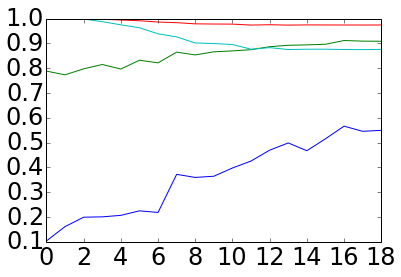

In [301]:
plt.plot([np.average(l) for l in zip(*list(f_score))])
plt.plot([np.average(l) for l in zip(*list(accuracy))])
plt.plot([np.average(l) for l in zip(*list(accuracy_t))])
plt.plot([np.average(l) for l in zip(*list(f_score_t))])

f = [np.average(l) for l in zip(*list(f_score))]
ft = [np.average(l) for l in zip(*list(f_score_t))]
a = [np.average(l) for l in zip(*list(accuracy))]
at = [np.average(l) for l in zip(*list(accuracy_t))]

In [302]:
avgs = pickle.load(open('Average F1-Scorea and Accuracy Squat.png','rb'))
avgsf = avgs[0]
avgsft = avgs[1]
avgsa = avgs[2]
avgsat = avgs[3]

In [303]:
# Only use this if you wish to add to existing f1 and average scores

# avgsf.append([np.average(l) for l in zip(*list(f_score))])
# avgsft.append([np.average(l) for l in zip(*list(f_score_t))])
# avgsa.append([np.average(l) for l in zip(*list(accuracy))])
# avgsat.append([np.average(l) for l in zip(*list(accuracy_t))])

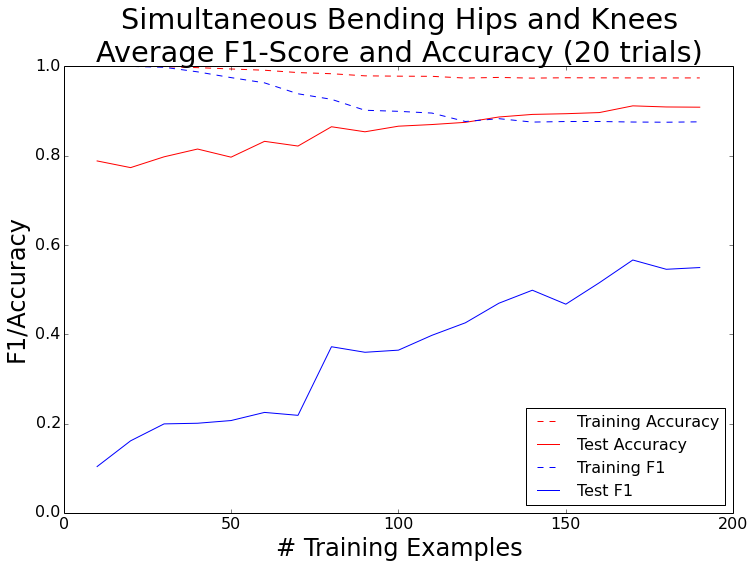

In [309]:
plot_keys = ['back_hip_angle', 'bend_hips_knees', 'stance_width', 'squat_depth','knees_over_toes']
num_training_examples = [x*10 for x in range(1,20)]
colors= ['k','r','r','b','g']

plt.plot(num_training_examples, at, color='r', linestyle='--', label='Training Accuracy')
plt.plot(num_training_examples, a, color='r', label='Test Accuracy')
plt.plot(num_training_examples, ft, color='b', linestyle='--', label='Training F1')
plt.plot(num_training_examples, f, color='b', label='Test F1')

plt.legend(loc='lower right', prop={'size':16})
plt.title('Simultaneous Bending Hips and Knees \nAverage F1-Score and Accuracy (20 trials)')
plt.xlabel('# Training Examples')
plt.ylabel('F1/Accuracy')
figure = plt.gcf() # get current figure
figure.set_size_inches(12, 8)
plt.rcParams.update({'font.size': 24})
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)
plt.axis([0, 200, 0, 1.0])
figure.savefig("bend_hips_knees.png", dpi = 200)

In [241]:
# pickle.dump([avgsf, avgsft, avgsa, avgsat],open('Average F1-Scorea and Accuracy Squat.png','wb'))